# Demand Estimation Exercise
### Part 0 : Getting started

In this assignment you will be doing guided demand estimation for heterogeneous product models. The techniques presented in this assignment are commonly used in research and for policy decisions. In this assignment we will focus on obtaining post-estimation elasticities of demand from two different models. Demand elasticites can only be obtained once we know the parameters defining the demand function. The purpose is that you understand how model misspecification leads to biased elasticities estimates and how such biases might impact policy and theoretical results. For the assignment you will use simulated data for which we exactly know the data generation process. A detailed description is provided below. 


**(a) Model description**

Consider a market with $N$ consumers, $J$ firms, across $T$ time periods (You can also see the time periods as geographically separated markets. This is an important assumption for heterogeneous product models, consumers can only activate within one market (Berry, 2021)). In this simplified model we assume firms are going to sell just one products, as such firms and product can be used interchangeably. The consumers have heterogeneous preferences over prices. The indirect utility of the consumers is going to be given by: 

$$u_{ijt} = \beta x_j + \alpha_{it}p_{jt} + \xi_{jt} + \varepsilon_{ijt}$$



Where: 
- $x_j$ is a  time invariant product characteristic 
-  $p_{jt}$ is the price of the product sold by firm $j$ in period $t$ 
- $\xi_{jt}$ are product-market specific fixed effects which are correlated with $p_{jt}$
- $\beta$ is the coefficient of the product characteristic and it is constant across consumers 
- $\alpha_{it}$ is the consumer specific price coefficient defined as $\alpha_{it} =  \mu_{\alpha} + \sigma_{\alpha} \nu_{it}^{p}$, where $\nu_{it}^{p}$ are i.i.d. standard normal random variables. 
-$\varepsilon_{ijt}$ is the error term following a Type 1 extreme value distribution 

Following from standard theory (ref slides) we know we can thereafter rewrite indirect utility as: 


$$u_{i j t}= \delta_{jt} + \sigma_{\alpha} \nu_{it}^{p}p_{jt} + \varepsilon_{ijt},$$ 

Where $ \delta_{jt} = \beta x_j + \mu_{\alpha} p_{jt} + \xi_{jt}$

Consumers purchase one unit of the good that gives them the highest utility. Each market has the same number of consumers across time, $N$. By assuming that the error term $\varepsilon_{ijt}$ follows from the type-I extreme value distribution, the probability $f_{ijt}$ that consumer $i$ buys product $j$ in market $t$ is given by the multinomial logit function: 


$$f_{ijt} = \frac{\exp \left(\beta x_j+\alpha_{it} p_{j t}+ \xi_{jt}\right)}{1+\sum_{k=1}^J \exp \left(\beta x_k + \alpha_{it} p_{k t} +\xi_{kt}\right)}.$$



Aggregating over the individual purchasing probabilities we get the market shares: 

$$
    s_{jt}= \int_N f_{ijt} \text{d} \nu.
$$


The model is a simplified and adapted version of the theory from the paper of \cite{berry1994estimating}. For additional information, clarification and theory please check the reference material. 

The assignment makes use of simulated data. The model has been calibrated to the following coefficients. These are the coefficients that you will try to estimate in the assignment. Ultimately, you will use the coefficients to retrive own-price elasticities of demand: 


| Coefficient    |   True Value   |
|----------------|------|
| $\mu_{\alpha}$    | -1.7 |
| $\beta$        | -1   |
| $\sigma_{\alpha}$ | 0.5  |


**(b) Load the neccesaty requirements**



In [33]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

### PART 1: Data exploration (10 points)


**Exercise 1**

 Look into the data characterizing you market. Print the data. Is it realistic that an econometrician has all the information that you have in your dataset (max 100x)?  

In [34]:
# 1. Load the data using pandas 
# Your code here 
df = pd.read_csv("simulation_data.csv")
# 2. Print the data
# Your code here 
print(df)


     market_ids  firm_ids    shares    prices      cost        xi     char1
0             1         1  0.000043  4.914348  3.262528 -0.042173  4.616823
1             1         2  0.000051  4.634007  3.331514 -0.135383  4.497339
2             1         3  0.000026  5.536855  3.358621  0.027024  4.888996
3             1         4  0.000038  4.896287  3.311746 -0.032851  4.744040
4             1         5  0.000022  6.333961  3.352858  0.219944  4.990127
..          ...       ...       ...       ...       ...       ...       ...
995         100         6  0.000048  4.293916  3.295705 -0.192426  4.682268
996         100         7  0.000030  6.300923  3.364446  0.177320  4.420019
997         100         8  0.000036  6.510156  3.351038  0.253008  4.217225
998         100         9  0.000017  7.528117  3.327199  0.394304  4.728908
999         100        10  0.000063  3.579614  3.364513 -0.438902  4.737151

[1000 rows x 7 columns]


*Your description here (double click to open markdown cell): 

**Exercise 2**

 Create a histogram with: 

1. The distribution of prices 
2. The distribution of market shares 

You should use the columns from the generated dataframe. 

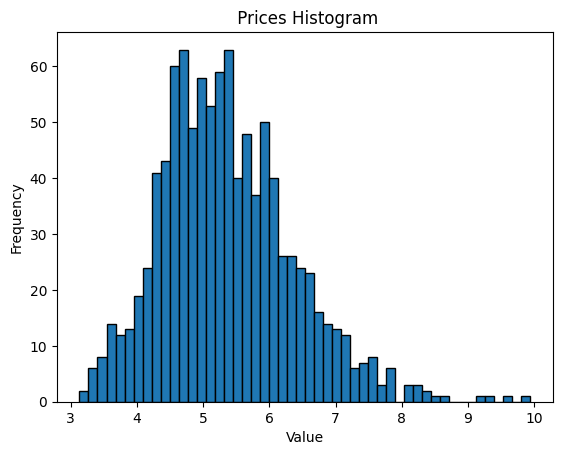

In [35]:
# Create the price histogram
# Your code here
plt.hist(df["prices"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(' Prices Histogram')

# Display the plot
plt.show()

*Your description here (double click to open markdown cell): 

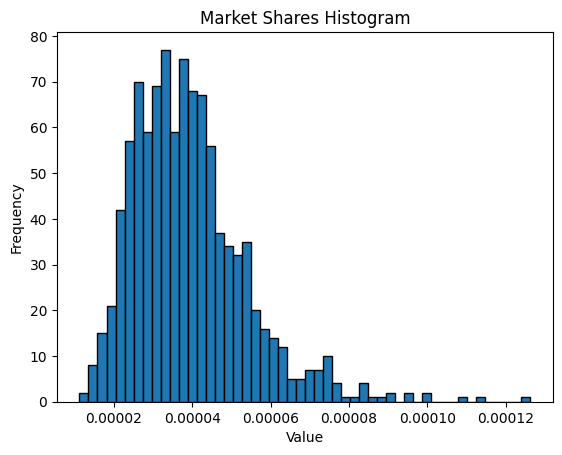

In [36]:
# Create a  shares histogram
# Your code here
plt.hist(df["shares"], bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Market Shares Histogram')

# Display the plot
plt.show()

*Your description here (double click to open markdown cell): 

### Part 2: Simple Logit Estimation (20 points)

**Exercise 1**

Estimate the simple logit model disregarding consumer heterogeneity
Trying to estimate with the logit function: 
$$ ln(s_j) - ln(s_0) =   \beta x_j + \alpha p_{jt} + \xi_{jt} $$


1. Calculate the outside good share $s_0$
2.  Create the dependent variable $\ln(s_{jt}) - \ln(s_{0t})$
3. Perform the regression and report the estimated coefficients


In [37]:
# Your code here 
df_group_marked_id = df.groupby('market_ids').sum()
outside_good_share = np.repeat((1 - np.array(df_group_marked_id['shares'])), 10)
y = np.log(df['shares']) - np.log(outside_good_share)
x = df[['prices','char1', 'xi']]


#  Use stats model for the regression
mod = sm.OLS(y, x).fit()
print(mod.summary()) 


                                 OLS Regression Results                                
Dep. Variable:                 shares   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.894e+05
Date:                Mon, 30 Oct 2023   Prob (F-statistic):                        0.00
Time:                        17:17:51   Log-Likelihood:                         -2.3955
No. Observations:                1000   AIC:                                      10.79
Df Residuals:                     997   BIC:                                      25.51
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Exercise 2**

Compare the estimates with the true estimates. What is wrong here? (100w)


Your explanation here (double click to open markdown cell):

/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_11232/3885381087.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = mod.params[i]
/var/folders/v2/756s2x392yg86b682tz_zrl80000gn/T/ipykernel_11232/3885381087.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = mod.bse[i]


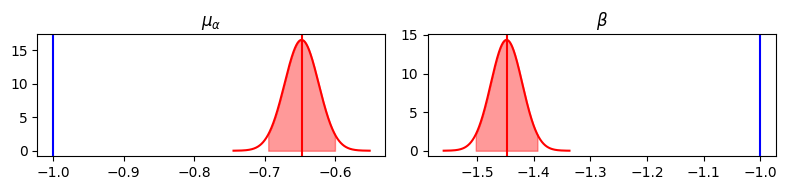

In [38]:
# Run the following visualization to put your results in perspective

fig, axes = plt.subplots(1, 2, figsize=(8, 2))

for i,ax in enumerate(axes.flatten()):
    ax.axvline(np.vstack((-1., -1.))[i], label="true", color="blue")

    # Plot (distribution of) estimated coefficient
    mu = mod.params[i]
    sigma = mod.bse[i]
    x1 = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    x2 = np.linspace(mu - 1.96*sigma, mu + 1.96*sigma, 1000)
    
    ax.axvline(mu, label="estimated", color="red")
    ax.plot(x1, norm.pdf(x1, mu, sigma), color="red")
    ax.fill_between(x2, norm.pdf(x2, mu, sigma), color="red", alpha=0.4)
    
    if i == 0:
        ax.set_title(r"$\mu_\alpha$")
    elif i == 1:
        ax.set_title(r"$\beta$")


plt.tight_layout()
plt.show()

**Exercise 3**

Describe what you see in the figures? How were the figures generated? (50w)

Your description here (double click on the text to open the cell):

### Part 3 - Guided Random Coefficients Estimation (40 points)

In this part of the exercise you are going to estimate a random coefficients model. Helper functions have been written for you. 

**Exercise 1**

Set the global variables characterizing the market. You should retrive this vairbales from the dataframe. Think about whether the dataframe tells you how many consumers are in the market. 

In [39]:
# Your code here 

# The number of firms 
n_firms = 10

# The number of consumers 
n_cons = 10000

# The number of time periods
T = 100

**Step 1**

Run the function that calcualtes simulated the random coefficients on price 


(Go a bit more on detail description on Monte Carlo simlation in price)

In [40]:
def gen_price_random_coeff(alpha_sd, v_p, df): 
        
        """
        TODO Add docstring
        """

        random_coefficient_prices = np.zeros((n_firms*n_cons*T, 1))
        alpha_i = np.zeros((n_cons*T, 1))
        for t in range(T):
            price_r = (np.array(df['prices'][t*n_firms : (t + 1)*n_firms])).reshape(1, n_firms)
            period_v_p = v_p[t*n_cons : (t + 1)*n_cons]
            alpha_i_per_period = np.reshape(alpha_sd*period_v_p, 
                                             (n_cons, 1))
            c_times_f = n_cons*n_firms
            alpha_i[t*n_cons: (t + 1)*n_cons] = alpha_i_per_period 
            reshaped =  np.reshape(np.ravel((alpha_i_per_period*price_r).T), (c_times_f, 1))
            random_coefficient_prices[t*c_times_f : (t + 1)*c_times_f] = reshaped
        return random_coefficient_prices

**Step 2**

Run the function that calculates estimated mean utilities 

In [41]:
def gen_estimated_utilities(alpha_mean, beta, df): 
    """
    TODO Add dosctring
    """
    estimated_mean_utlities = np.zeros((n_firms*T, 1))
    for t in range(T):
        price_r = np.array(df['prices'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        product_chars_period = np.array(df['char1'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        xi_per = np.array(df['xi'][t*n_firms : (t + 1)*n_firms]).reshape(n_firms, 1)
        mean_indirect_utilities_period = beta*product_chars_period + alpha_mean*price_r + xi_per
        reshaped = np.reshape(mean_indirect_utilities_period, (n_firms, 1))
        estimated_mean_utlities[t*n_firms:(t + 1)*n_firms] = reshaped
    return estimated_mean_utlities


**Step 3** 

Run the function that calculates estimates market shares

In [42]:
def gen_estimated_market_share(theta, v_p, df):

    """
    TODO
    """


    alpha_sd = theta[0]
    alpha_mean = theta[1]
    beta = theta[2]

    estimated_market_shares = np.zeros((n_firms*T, 1))
    random_coeff_price = gen_price_random_coeff(alpha_sd, v_p, df)
    mean_utilities = gen_estimated_utilities(alpha_mean, beta, df)
    
    for t in range(T):
        c_times_f = n_cons*n_firms
        coeff_per_T = random_coeff_price[t*c_times_f : (t + 1) * c_times_f]
        repeat_u = np.repeat(mean_utilities[t*n_firms : (t + 1)*n_firms]
                             , n_cons, axis=0)                
        u = repeat_u + coeff_per_T 
        u_r = np.reshape(u, (n_firms, n_cons))
        sum_u = np.sum(np.exp(u_r), axis=0)
        all_probs = np.exp(u_r)/(1 + sum_u)
        market_shares = np.sum(all_probs, axis=1)/n_cons
        reshaped = np.reshape(market_shares, (n_firms, 1))
        estimated_market_shares[t*n_firms:(t + 1)*n_firms] = reshaped

    return estimated_market_shares

**Exercise 2** 

Write the ojective function of the optimization. The objective function should minimize the distance between the true share vector and the estimated share vector. 

In [43]:
# Your code here

def f(theta, v_p, df):
    true_shares = np.array(df['shares'])
    estimated_market_shares = gen_estimated_market_share(theta, v_p, df)
    # val = np.linalg.norm(np.log(true_shares) -  np.log(estimated_market_shares))
    A = np.log(true_shares)
    B = np.log(estimated_market_shares)
    val = np.square(np.subtract(A, B)).mean()
    return val

**Exercise 3** 

Optimize your function f using scipy.optimize.minimize. 


TODO: Describe why they need to do the optimization multiple times

Again here more detail into the Monte Carlo simulation and approximation of the shocks

In [44]:
theta_0= [0.5, -0.6477, -1.4479]


N_simulation = 5

results = np.zeros((N_simulation, 3))

for n in range(N_simulation):
    v_p_monte = np.random.normal(0, 1, (n_cons*T, 1))
    res = optimize.minimize(f, theta_0, args=(v_p_monte, df), bounds=((0., 1.), (-3., -1.), (-2., -0.5)))
    results[n,:] = res.x



print(results)


[[ 0.58017921 -1.90123498 -1.0111024 ]
 [ 0.5724882  -1.84234464 -1.04922976]
 [ 0.56642489 -1.80608692 -1.07203947]
 [ 0.51915748 -1.62659334 -1.13919083]
 [ 0.57999214 -1.86945233 -1.0381225 ]]


**Exercise 4**


Calculate the mean value of the coefficients over all the Monte Carlo simulations. How do these results compare to your results in Part 2?

In [45]:
# Your code here 
print(results.mean(axis=0))


[ 0.56364838 -1.80914244 -1.06193699]


Your discussion here (max 150w)

### Part 4: Calculate price elasticies (30 points)
Calculate average own-price elasticities with simple logit and the random coefficients estimates and discuss your results (max 150w). 

Use the following formula: 







In [ ]:
# Your code here for estimates from the simple logit estimation


In [ ]:
# Your code here for estimates from the random coefficients estimation 

Your discussion here (max 150w)

### Part 5. Bonus Question (not mandatory)

Estimate the model in the more realistic case where you do not know the product-specific fixed efffects $\xi$. For this you can use the costs in the dataframe as instruments. 

In the _outer loop_, the GMM estimation procedure relies on the properties of the price instruments in order to retrieve the unbiased price coefficients. For this estimation, you have to use supply side instruments.

Make use of the functions build for you in the guided Monte Carlo Estimation. Make use of the description offered by (Nevo, 2000)



### References


Berry, S. T., & Haile, P. A. (2020). Nonparametric identification of differentiated products demand using micro data (No. w27704). National Bureau of Economic Research.


Nevo, A. (2000). A practitioner's guide to estimation of random‐coefficients logit models of demand. Journal of economics & management strategy, 9(4), 513-548.
Chicago	

